In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import cosine

# Setup for K Means Clustering

In [91]:
# Initialize centroids to existing points
def initialize_centroids(data, k):
    return data.sample(n = k).to_numpy()

# Calculate distances to each cluster and assign to nearest
def assign_clusters(data, centroids):
    distances = np.linalg.norm(data.to_numpy()[:, np.newaxis] - centroids, axis = 2)
    return np.argmin(distances, axis = 1)

# Update centroid locations after a round of assignments
def update_centroids(data, labels, k):
    new_centroids = []
    for i in range(k):
        cluster_points = data[labels == i]
        new_centroids.append(cluster_points.mean().to_numpy())
    
    return np.array(new_centroids)

def kmeans(data, k, max_iters = 100, tol = 1e-4):
    centroids = initialize_centroids(data, k)
    
    for _ in range(max_iters):
        labels = assign_clusters(data, centroids)
        new_centroids = update_centroids(data, pd.Series(labels), k)
        if np.all(np.linalg.norm(centroids - new_centroids, axis = 1) < tol):
            break
        centroids = new_centroids
        
    return labels, centroids

# Setup for Hierarchical Clustering

In [92]:
# Calculate cosine distances
def cosine_distance_matrix(data):
    n = len(data)
    dist_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i + 1, n):
            d = cosine(data[i], data[j])
            dist_matrix[i, j] = d
            dist_matrix[j, i] = d
    return dist_matrix

def hierarchical_clustering(data, n_clusters):
    X = data.to_numpy()
    n_samples = X.shape[0]
    
    # Initialize each point to its own cluster
    clusters = {i: [i] for i in range(n_samples)}
    dist_matrix = cosine_distance_matrix(X)

    # Fill in self distances
    np.fill_diagonal(dist_matrix, np.inf)
    
    linkage_matrix = []
    current_cluster_id = n_samples
    
    # Merge until the cluster threshold is reached
    while len(clusters) > n_clusters:
        min_dist = np.inf
        merge_pair = None
        
        keys = list(clusters.keys())
        # Find closest pair to merge
        for i in range(len(keys)):
            for j in range(i + 1, len(keys)):
                c1, c2 = keys[i], keys[j]
                dists = [dist_matrix[p1, p2] for p1 in clusters[c1] for p2 in clusters[c2]]
                avg_dist = np.mean(dists)
                
                if avg_dist < min_dist:
                    min_dist = avg_dist
                    merge_pair = (c1, c2)
        
        # Merge the closest pair
        c1, c2 = merge_pair
        new_cluster = clusters[c1] + clusters[c2]
        
        # Record the merge
        linkage_matrix.append([c1, c2, min_dist, len(new_cluster)])
        
        # Update clusters
        clusters[current_cluster_id] = new_cluster
        del clusters[c1]
        del clusters[c2]
        
        current_cluster_id += 1
    
    # Compile and label the clusterings
    linkage_matrix = np.array(linkage_matrix)
    labels = np.zeros(n_samples, dtype = int)
    for cluster_id, points in enumerate(clusters.values()):
        for p in points:
            labels[p] = cluster_id
    
    return labels, linkage_matrix

# Setup for plotting

In [93]:
# K Means plotting
def plot_clusters_k_means(data, features_list, labels, centroids):
    plt.figure(figsize = (8, 6))
    k = len(np.unique(labels))
    for i in range(k):
        cluster_points = data[np.array(labels) == i]
        plt.scatter(cluster_points[features_list[0]], cluster_points[features_list[1]], label = f"Cluster {i}")
    plt.scatter(centroids[:, 0], centroids[:, 1], c = "black", marker = 'X', s = 200, label = "Centroids")
    plt.title(f"Scatterplot of K-Means Clustering on {features_list[0]} vs {features_list[1]}")
    plt.xlabel(features_list[0])
    plt.ylabel(features_list[1])
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_dendrogram_k_means(data):
    plt.figure(figsize = (10, 6))
    dendrogram(linkage(data, method = "ward"), orientation = "top", distance_sort = "descending", show_leaf_counts = False)
    plt.title("K Means Clustering Dendrogram")
    plt.xlabel("Sample index")
    plt.ylabel("Distance")
    plt.grid(True, axis = 'y')
    plt.show()

# Hierarchical plotting
def plot_clusters_hierarchical(data, features_list, labels):
    plt.figure(figsize = (8, 6))
    k = len(np.unique(labels))
    for i in range(k):
        cluster_points = data[np.array(labels) == i]
        plt.scatter(cluster_points[features_list[0]], cluster_points[features_list[1]], label=f"Cluster {i}")
    plt.title(f"Scatterplot of Hierarchical Clustering on {features_list[0]} vs {features_list[1]}")
    plt.xlabel(features_list[0])
    plt.ylabel(features_list[1])
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_dendrogram_hierarchical(linkage_matrix):
    plt.figure(figsize = (10, 6))
    dendrogram(linkage_matrix, orientation = "top", distance_sort = "descending", show_leaf_counts = False)
    plt.title("Hierarchical Clustering Dendrogram")
    plt.xlabel("Sample index")
    plt.ylabel("Distance")
    plt.grid(True, axis = 'y')
    plt.show()

# Setup for Silhouette Method

In [94]:
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))

def silhouette_score(X, labels):
    # X is the raw data
    # labels is the cluster assignments list resulting from K Means Clustering
    n = X.shape[0]
    unique_labels = np.unique(labels)
    silhouette_scores = []

    for i in range(n):
        own_cluster = labels[i]
        own_cluster_points = X[labels == own_cluster]
        other_clusters = [label for label in unique_labels if label != own_cluster]

        # Compute a(i)
        # Dissimilarity score to i's assigned cluster
        a = np.mean(
            [euclidean_distance(X[i], point) for point in own_cluster_points if not np.array_equal(X[i], point)]
        )

        # Compute b(i)
        # Dissimilarity score to the other cluster with the lowest mean distance
        b = np.min([
            np.mean(
                [euclidean_distance(X[i], point) for point in X[labels == other_label]]
            ) for other_label in other_clusters
        ])

        # Compute s(i)
        s = (b - a) / max(a, b) if max(a, b) > 0 else 0
        silhouette_scores.append(s)

    return np.mean(silhouette_scores)

# Import the dataset

And initialize the features to focus on

In [99]:
# Changing these features creates the graphs shown on the webpage
# They are not repeated here
features = ["SOE", "SDA"]
df = pd.read_csv("epi_cleaned.csv")[features]
df.head()

,SOE,SDA
0,0.002284,0.379995
1,0.006019,-0.066417
2,0.014059,-0.033639
3,0.001824,-0.026659
4,0.002399,0.046873


Find and plot the silhouette scores for k values between 2 and 10

K = 2, Silhouette Score = 0.56
K = 3, Silhouette Score = 0.48
K = 4, Silhouette Score = 0.39
K = 5, Silhouette Score = 0.44
K = 6, Silhouette Score = 0.50


c:\Users\malfo\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\malfo\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


K = 7, Silhouette Score = 0.48
K = 8, Silhouette Score = 0.49
K = 9, Silhouette Score = 0.47
K = 10, Silhouette Score = 0.44


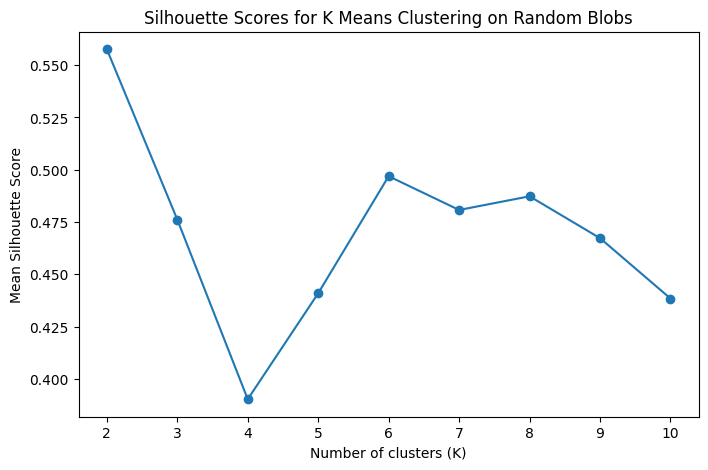

In [96]:
k_values = range(2, 11)
mean_silhouette_scores = []
for k in k_values:
    labels, centroids = kmeans(df, k)
    score = silhouette_score(df.values, labels)
    mean_silhouette_scores.append(score)
    print(f"K = {k}, Silhouette Score = {score:.2f}")

# Plot silhouette scores
plt.figure(figsize = (8, 5))
plt.plot(k_values, mean_silhouette_scores, marker = 'o')
plt.title("Silhouette Scores for K Means Clustering on Random Blobs")
plt.xlabel("Number of clusters (K)")
plt.ylabel("Mean Silhouette Score")
plt.show()

# Run and plot K Means Clustering (with optimal K)

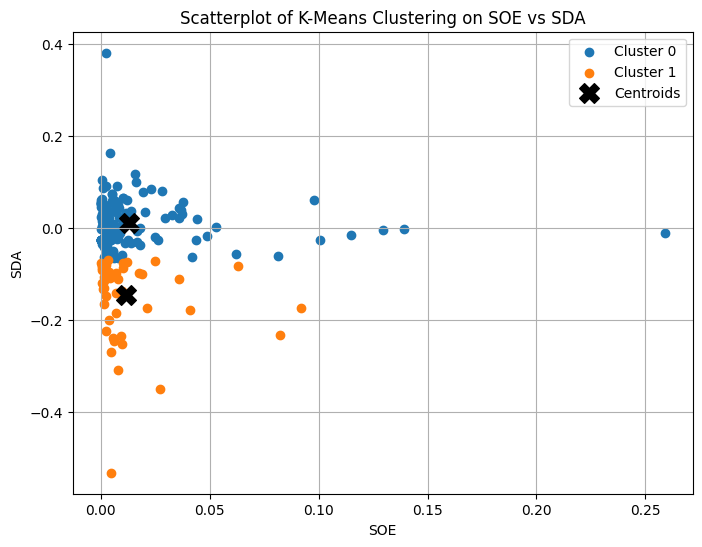

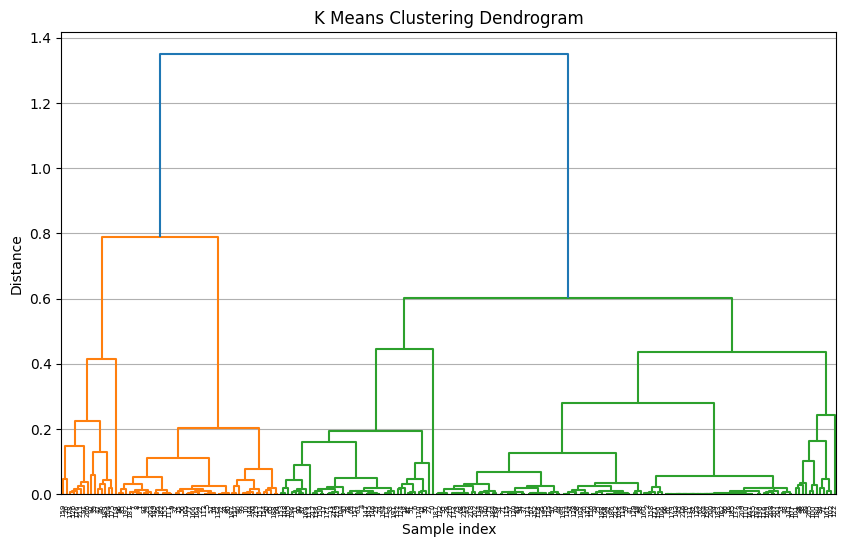

In [97]:
k = 2
labels, centroids = kmeans(df, k)
plot_clusters_k_means(df, features, labels, centroids)
plot_dendrogram_k_means(df)

# Run and plot Hierarchical Clustering (with optimal K)

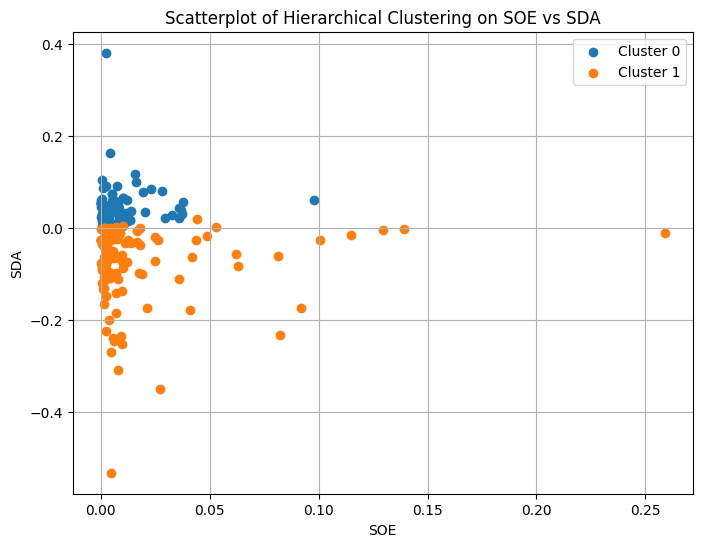

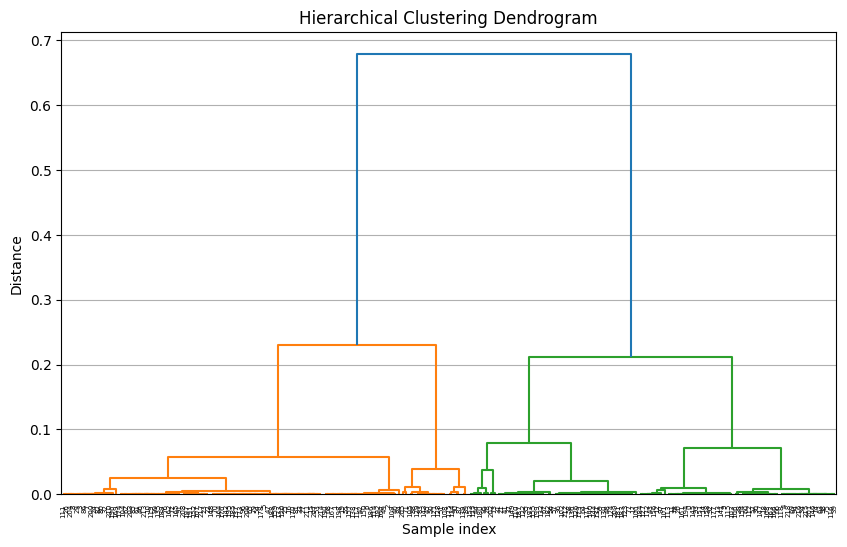

In [98]:
k = 2
labels, linkage_matrix = hierarchical_clustering(df, n_clusters = k)
plot_clusters_hierarchical(df, features, labels)
plot_dendrogram_hierarchical(linkage_matrix)